In [1]:
from google.colab import drive
drive.mount('/content/drive/')

from drive.MyDrive.kursach import helpers
path = 'drive/MyDrive/kursach/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install segmentation_models_pytorch

In [3]:
import copy
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn import model_selection
import torch
from torch import nn
from torch.utils import data

In [4]:
rand = 51
np.random.seed(rand)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Простейшая нейросеть (без предварительной обработки данных)

Напишем unet-нейросеть, которая определяет, где легкие, а где фон.

In [6]:
im_medseg, mk_medseg, im_radio, mk_radio = helpers.load_datasets(path, size=(256, 256))

Added drive/MyDrive/kursach/raw-data-kaggle/images_medseg.npy, shape (1, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_medseg.npy, shape (4, 100, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/images_radiopedia.npy, shape (1, 829, 256, 256)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_radiopedia.npy, shape (4, 829, 256, 256)


In [7]:
X = np.concatenate((im_medseg[0], im_radio[0]), axis=0)
y = np.concatenate((mk_medseg, mk_radio), axis=1)[3]
y = np.where(y, 0, 1)

X.shape, y.shape

((929, 256, 256), (929, 256, 256))

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, random_state=rand)

In [9]:
gc.collect()

184

In [10]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32)).to(device)
        self.X = self.X.reshape(-1, 1, X.shape[1], X.shape[2])
        self.y = torch.from_numpy(y.astype(np.int64)).to(device)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.y[i]

def get_loader(dataset, batch=64):
  return torch.utils.data.DataLoader(dataset, batch_size=batch)

In [11]:
train = Dataset(X_train, y_train)
test = Dataset(X_test, y_test)

In [12]:
class Network:
    def __init__(self, model, loss):
        self.model = model.to(device)
        self.loss = loss
        self.optim = torch.optim.Adam(self.model.parameters())

    def fit(self, data, epochs=50, verbose=False):
      data = get_loader(data)
      size = len(data)
      for i in range(epochs):
        total_loss = 0
        for batch, (X, y) in enumerate(data):
          pred = self.model(X)
          loss = self.loss(pred, y)
          total_loss += loss.detach().to('cpu').item()

          self.optim.zero_grad()
          loss.backward()
          self.optim.step()

        if verbose:
          print(f'Epoch {i}, loss {total_loss}')

    def fit_best(self, train, epochs=50, test_metric='accuracy'):
      size = len(train)
      lengths = [int(size * 0.8), size - int(size * 0.8)]
      best_model = None
      best_score = 0.
      no_improvements = 0

      for i in range(epochs):
        print(f'Epoch {i}')
        if i % 3 == 0:
          cur_train, cur_test = torch.utils.data.random_split(train, lengths)
        # train phase
        self.fit(cur_train, epochs=1)
        # test phase
        score = self.test(cur_test, test_metric)
        if score > best_score:
          best_score = score
          best_model = copy.deepcopy(self.model)
          print(f'Improved score: {best_score}')
          no_improvements = 0
        else:
          no_improvements += 1

        if no_improvements >= 5:
          break

      self.model = best_model


    def test(self, data, metric, *args):
      data = get_loader(data)
      size = len(data.dataset)
      num_batches = len(data)
      total_metric = 0.

      with torch.no_grad():
        for X, y in data:
          pred = self.model(X).argmax(1)
          if metric == 'accuracy':
            total_metric += self._accuracy(pred, y)
          elif metric == 'iou':
            iou = self._iou(pred, y, args[0])
            total_metric += self._iou(pred, y, args[0])

      if metric == 'accuracy':
        total_metric /= size
      elif metric == 'iou':
        total_metric /= num_batches

      return total_metric

    def _accuracy(self, y_pred, y_true):
      im_size = y_pred.shape[1] * y_pred.shape[2]
      return (y_pred == y_true).type(torch.float).sum().item() / im_size

    def _iou(self, y_pred, y_true, class_label):
      y_pred = y_pred == class_label
      y_true = y_true == class_label
      intersection = y_pred & y_true
      union = y_pred | y_true
      return intersection.type(torch.float).sum().item() / union.type(torch.float).sum().item()

In [13]:
model = Network(smp.Unet(in_channels=1, classes=2, activation='softmax'),
                nn.CrossEntropyLoss())

In [14]:
model.fit(train, epochs=20, verbose=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch 0, loss 5.427385121583939
Epoch 1, loss 4.162328362464905
Epoch 2, loss 3.979196220636368
Epoch 3, loss 3.914122521877289
Epoch 4, loss 3.884425938129425
Epoch 5, loss 3.8673532903194427
Epoch 6, loss 3.856311321258545
Epoch 7, loss 3.8470470309257507
Epoch 8, loss 3.8396683633327484
Epoch 9, loss 3.8347623348236084
Epoch 10, loss 3.8295398354530334
Epoch 11, loss 3.82531401515007
Epoch 12, loss 3.8211996257305145
Epoch 13, loss 3.8180893063545227
Epoch 14, loss 3.814820259809494
Epoch 15, loss 3.8127183616161346
Epoch 16, loss 3.8106391727924347
Epoch 17, loss 3.8087550699710846
Epoch 18, loss 3.8078792691230774
Epoch 19, loss 3.8073409497737885


In [15]:
model.test(test, 'accuracy')

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


0.9953423776934224

In [16]:
model.test(test, 'iou', 1)

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


0.9727127372233489

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


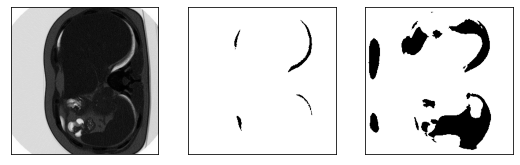

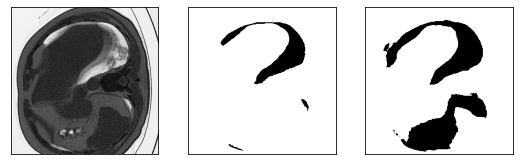

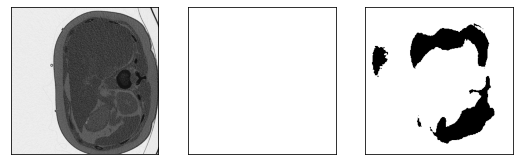

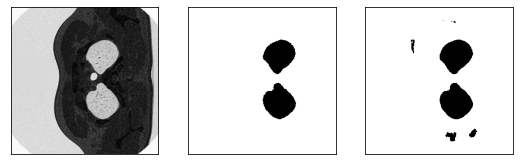

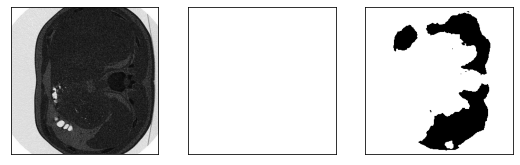

In [17]:
for i in range(5):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0], true_answer, pred_answer[0]]
  images = [im.cpu().detach().numpy() for im in images]
  helpers.show_im_row(np.array(images), size=3)

Результат, в целом, хороший (даже подозрительно слишком хороший...). Попробуем проделать то же для четырех классов.

In [18]:
y = np.concatenate((mk_medseg, mk_radio), axis=1)
y = y.argmax(0)
y.shape

(929, 256, 256)

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, random_state=rand)
train = Dataset(X_train, y_train)
test = Dataset(X_test, y_test)

In [20]:
model = Network(smp.Unet(in_channels=1, classes=4, activation='softmax'),
                nn.CrossEntropyLoss())

In [21]:
model.fit(train, epochs=20, verbose=True)

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch 0, loss 14.587827920913696
Epoch 1, loss 12.128092885017395
Epoch 2, loss 10.881356656551361
Epoch 3, loss 9.986407339572906
Epoch 4, loss 9.53140276670456
Epoch 5, loss 9.324876010417938
Epoch 6, loss 9.232240378856659
Epoch 7, loss 9.188054203987122
Epoch 8, loss 9.164359509944916
Epoch 9, loss 9.149217545986176
Epoch 10, loss 9.133255183696747
Epoch 11, loss 9.1224085688591
Epoch 12, loss 9.114299237728119
Epoch 13, loss 9.109640300273895
Epoch 14, loss 9.107091248035431
Epoch 15, loss 9.097290098667145
Epoch 16, loss 9.087928056716919
Epoch 17, loss 9.085000038146973
Epoch 18, loss 9.078483581542969
Epoch 19, loss 9.079593122005463


In [22]:
model.test(test, 'accuracy')

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


0.9875284010364164

In [23]:
for i in range(4):
  print(model.test(test, 'iou', i))

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


0.6076571441590297
0.4004671500478046
0.9299836169869272
0.993788835648674


Видим, что модель научилась хорошо находить самые "простые" классы - легкие и фон. А вот с классами, которые нас интересуют больше всего, имеются проблемы.

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


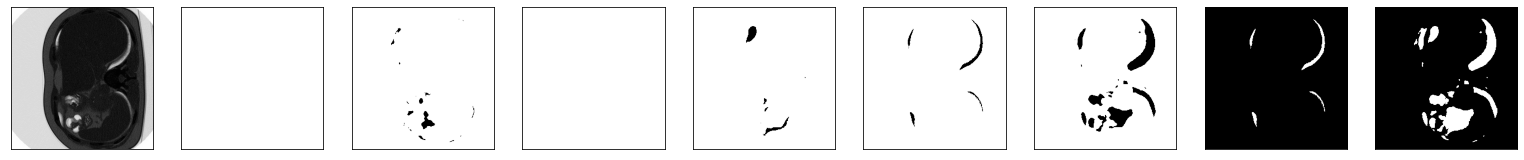

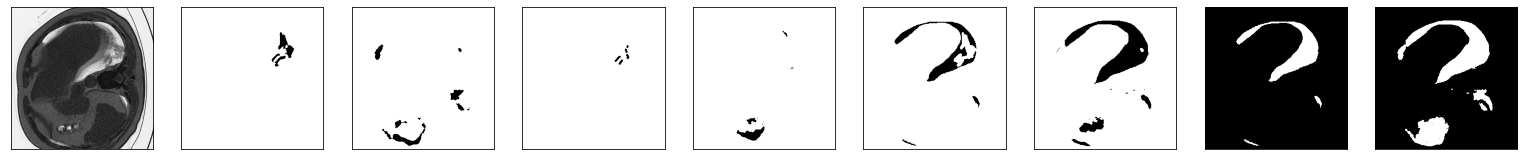

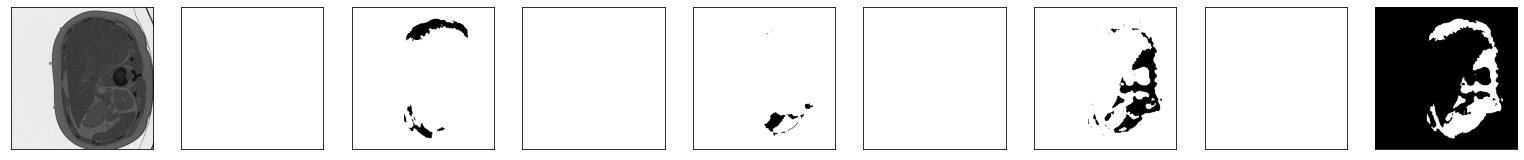

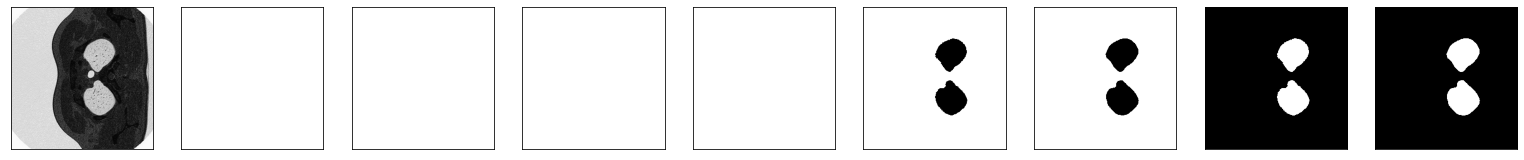

In [24]:
for i in range(4):
  sample, true_answer = test[i]
  pred_answer = model.model(sample.reshape(1, 1, sample.shape[1], -1)).argmax(1)
  images = [sample[0]]
  for j in range(4):
    images += [true_answer == j, (pred_answer == j)[0]]
  images = [im.cpu().detach().numpy() for im in images]
  helpers.show_im_row(np.array(images), size=3)